In [26]:
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

### Comparing context summaries [RAG] with generated summaries [Finetuned ZS]

In [2]:
compare_summaries = pd.read_csv('compare_summaries.csv')

is_match = list(compare_summaries['is_match']) 
is_common = list(compare_summaries['is_common'])
print(f"% match in summaries: {np.round(sum(is_match)/len(is_match) * 100, 2)}%")

% match in summaries: 61.54%


In [3]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(is_common, is_match)
print(cm)

print(f"Total number of functions understood: {np.round(sum(is_match)/len(is_match) * 100, 2)}%")
print(f"Total number of common functions understood: {np.round(cm[1][1]/(cm[1][0] + cm[1][1]) * 100, 2)}%")
print(f"Total number of corpus-specific functions understood: {np.round(cm[0][1]/(cm[0][0] + cm[0][1]) * 100, 2)}%")

[[12  4]
 [ 3 20]]
Total number of functions understood: 61.54%
Total number of common functions understood: 86.96%
Total number of corpus-specific functions understood: 25.0%


In [4]:
corpus_understood = list(compare_summaries[(compare_summaries['is_match'] == 1) & (compare_summaries['is_common'] == 0)]["Entities"])
common_understood = list(compare_summaries[(compare_summaries['is_match'] == 1) & (compare_summaries['is_common'] == 1)]["Entities"])

corpus = list(compare_summaries[compare_summaries['is_common'] == 0]["Entities"])
common = list(compare_summaries[compare_summaries['is_common'] == 1]["Entities"])

#### Reason

In [23]:
from datasets import load_dataset

dataset_name = "lamini/lamini_docs"
datasets = load_dataset(dataset_name)

data = []

for qa_pair in datasets['train']:
    _sentence = (qa_pair['question'] + ' ' + qa_pair['answer']).replace("\\n", " ")
    data.append(_sentence)

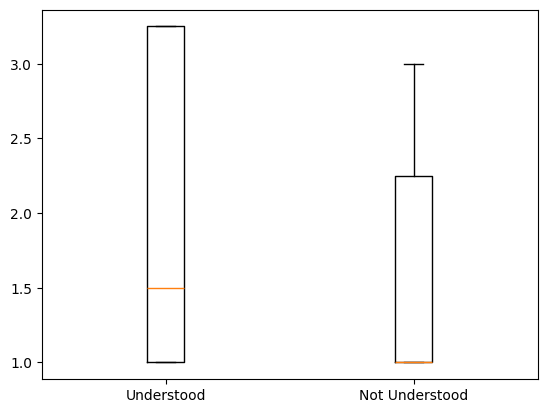

In [44]:
entities = list(compare_summaries["Entities"])

count = {}

for e in entities:
    _count = 0
    for d in data:
        if e in d:
            _count += 1
    count[e] = _count

understood_count = []
not_understood_count = []

for e in corpus_understood:
    understood_count.append(count[e])

for e in list(set(corpus) - set(corpus_understood)):
    not_understood_count.append(count[e])

plt.boxplot([understood_count, not_understood_count], labels=['Understood', 'Not Understood'], showfliers=False)
plt.show()

### Comparing Inverted Question Answers with Actual Summary

In [5]:
df = pd.read_csv("summary.csv")
expected_answers = list(df["Entity"])
summaries = list(df["Summary"])

generated_answers = pkl.load(open("inverted_questions_answers.pkl", "rb"))

In [10]:
match = 0
matched_entities = []
matched_summary = []

for (e, g, s) in zip(expected_answers, generated_answers, summaries):
    if e.lower() in g.lower():
        match += 1
        matched_entities.append(e)
        matched_summary.append(s)

print(f"Common functions retrieved: {np.round(len(set(matched_entities).intersection(common_understood))/len(common_understood) * 100, 2)}%")
print(f"Corpus functions retrieved: {np.round(len(set(matched_entities).intersection(corpus_understood))/len(corpus_understood) * 100, 2)}%")
print(f"Total functions retrieved: {np.round(len(matched_entities)/(len(corpus_understood) + len(common_understood)) * 100, 2)}%")

Common functions retrieved: 45.0%
Corpus functions retrieved: 0.0%
Total functions retrieved: 37.5%


### False Confidence Test

In [79]:
match_inverted_questions = []

for e in matched_entities:
    inverted_question = df.loc[df["Entity"] == e]["Inverted Questions"].iloc[0]
    match_inverted_questions.append(inverted_question)

match_inverted_questions

["What function in Lamini terminates a running job by sending a request to the server, releasing any resources used, and returning a response indicating the cancellation's success or failure?",
 'What function in Lamini offers real-time updates on the status of a job, including its progress, completion, or failure, and may provide additional details such as timestamps and error messages?',
 'What parameter allows for custom filtering of generated output based on a provided function?',
 'What function in Lamini retrieves a response from the Llama API and handles errors by retrying up to 5 times before raising a runtime error?',
 'What parameter in Lamini limits the number of retries in case the generated output does not satisfy a specified condition?',
 'What parameter in Lamini controls the maximum length of generated text outputs, allowing for precise control over text length?',
 'What parameter in Lamini allows users to specify the name of a pre-trained language model to use for text

In [80]:
import csv

with open('matched_entities.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["Entities", "Summary", "Inverted Questions"])
    for x, y, z in zip(matched_entities, matched_summary, match_inverted_questions):
        writer.writerow([x, y, z])

In [3]:
df = pd.read_csv("matched_entities.csv")
expected_answers = list(df["Entities"])

generated_answers = pkl.load(open("fct_answers.pkl", "rb"))

correct_answers = 0
correct_entity = []

for (e, g) in zip(expected_answers, generated_answers):
    if e.lower() in g.lower():
        correct_answers += 1
        correct_entity.append(e)

print(f"% of correct answers from the FCT : {np.round(correct_answers/len(expected_answers) * 100, 2)}%")
print(correct_entity)

% of correct answers from the FCT : 11.11%
['filter_fn']


In [ ]:
# Reasoning Abilities

"""
Enter the prompt: Are both .query() in H2O.ai and filter_fn in Lamini used for filtering data?
 
### Answer: Yes, both H2O.ai's.query() and Lamini's filter_fn are used for filtering data. .query() in H2O.ai is used to create a query that filters the data, while filter_fn in Lamini is a function that takes in a data generator and returns a filtered data generator.  Both are used to select specific data points that meet certain criteria, such as filtering out outliers or selecting only
********************************************************************************

Enter the prompt: Is there any similarity between the .query() in H2O.ai and filter_fn in Lamini?
 
### Answer: There is no similarity between the.query() in H2O.ai and filter_fn in Lamini as they serve different purposes. The.query() method in H2O.ai is used to specify the query parameters for a query operation, while the filter_fn parameter in Lamini is used to define a filter function that is applied to the input data before it is passed to the LLM engine. 
"""

### Comparing generated summary with actual summary

In [4]:
generated_summary = pkl.load(open("generated_summary.pkl", "rb"))   

clean_summary = []
for x in generated_summary:
    clean_summary.append(x.split('###')[1][9:].strip())

acutal_summary = list(df["Summary"])
actual_summary = [x .strip() for x in acutal_summary]

In [14]:
for (c, a) in zip(clean_summary, actual_summary):
    print(c)
    print(a)
    print("\n")

The add_data function/parameter allows for the addition of new data to the LLM Engine, which can be used to improve its performance and accuracy. 30 words.
The `add_data()` function in Lamini allows you to add training data to the LLM Engine, enabling the model to learn and improve its performance.


The add_improve_statements function/parameter allows for the addition of new statements to improve the model's performance. 30 words.
In Lamini, the `add_improve_statements()` function allows adding multiple improve statements to the LLM engine.


The add_metric function/parameter allows users to track and evaluate the performance of LLMs on specific tasks or metrics. 30 words.
The `add_metric` method in Lamini allows you to add a metric to compare the generated output to a target output, and train the LLM Engine using the `fit` method.


The add_model function/parameter allows for the addition of multiple models to the LLM Engine in Lamini. 30 words.
The "add_model" method in Lamini's pyt